In [1]:
# This is to rain and test the Official YOLOv7 on Hard Hat dataset.
# Note: the notebook was run using the "Python 3 (ipykernel)" in AML.

# He Zhang, Sep. 2022

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("GPU:", torch.cuda.device_count(), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("NO GPU")

Torch: 1.8.2+cu102
Torchvision: 0.9.2+cu102
GPU: 4 Tesla M60


In [3]:
# go to folder YOLOv7
%cd yolov7/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/multi-gpu-4-tesla-m60/code/Users/zhanghe/cv-safety-detection/yolov7


In [7]:
%%writefile ./data/hardhat7041yolov7.yaml

# train & val & test sets
train: ../datasets/hard_hat_workers_dataset/images/train
val: ../datasets/hard_hat_workers_dataset/images/test
test: ../datasets/hard_hat_workers_dataset/images/test # test images (optional)

# number of classes
nc: 3

# class names
names: ["head", "helmet", "person"]

Overwriting ./data/hardhat7041yolov7.yaml


In [6]:
# train
!python -m torch.distributed.launch --nproc_per_node 4 train.py --sync-bn --img 544 544 --batch-size 20 --epochs 10 --data data/hardhat7041yolov7.yaml --name exp_hardhat --cfg cfg/training/yolov7-hardhat-dataset.yaml --weights yolov7.pt --hyp data/hyp.scratch.custom.yaml --workers 8 --device 0,1,2,3

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
YOLOR 🚀 2022-8-31 torch 1.8.2+cu102 CUDA:0 (Tesla M60, 8129.25MB)
                                    CUDA:1 (Tesla M60, 8129.25MB)
                                    CUDA:2 (Tesla M60, 8129.25MB)
                                    CUDA:3 (Tesla M60, 8129.25MB)

Added key: store_based_barrier_key:1 to store for rank: 0
Namespace(adam=False, artifact_alias='latest', batch_size=5, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7-hardhat-dataset.yaml', data='data/hardhat7041yolov7.yaml', device='0,1,2,3', entity=None, epochs=300, evolve=False, exist_ok=False, freeze=[0], global_rank=0, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[544, 544], label_smoot

 85                -1  1    147712  models.common.Conv                      [128, 128, 3, 1]              
 86                -1  1    147712  models.common.Conv                      [128, 128, 3, 1]              
 87[-1, -2, -3, -4, -5, -6]  1         0  models.common.Concat                    [1]                           
 88                -1  1    262656  models.common.Conv                      [1024, 256, 1, 1]             
 89                -1  1         0  models.common.MP                        []                            
 90                -1  1     66048  models.common.Conv                      [256, 256, 1, 1]              
 91                -3  1     66048  models.common.Conv                      [256, 256, 1, 1]              
 92                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]              
 93      [-1, -3, 51]  1         0  models.common.Concat                    [1]                           
 94                -1  1    525

In [8]:
# evaluate
%run -i test.py --weights runs/train/exp_hardhat_img544_epoch300/weights/best.pt --data data/hardhat7041yolov7.yaml --name exp_hardhat_img544_epoch300

YOLOR 🚀 2022-9-2 torch 1.8.2+cu102 CUDA:0 (Tesla M60, 8129.25MB)
                                   CUDA:1 (Tesla M60, 8129.25MB)
                                   CUDA:2 (Tesla M60, 8129.25MB)
                                   CUDA:3 (Tesla M60, 8129.25MB)



Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/hardhat7041yolov7.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='exp_hardhat_img544_epoch300', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['runs/train/exp_hardhat_img544_epoch300/weights/best.pt'])
Fusing layers... 


Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



val: Scanning '../datasets/hard_hat_workers_dataset/labels/test' images and labels... 1766 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 1766/1766 [03:11<00:00,  9.22it/s]
val: New cache created: ../datasets/hard_hat_workers_dataset/labels/test.cache
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it]


                 all        1766        6808       0.657       0.664       0.662       0.455
                head        1766        1803        0.92       0.966       0.973       0.671
              helmet        1766        4863       0.938       0.969       0.988       0.679
              person        1766         142       0.114      0.0563      0.0262      0.0155
Speed: 26.9/1.3/28.2 ms inference/NMS/total per 640x640 image at batch-size 32
Results saved to runs/test/exp_hardhat_img544_epoch300


In [9]:
# infer
%run -i detect.py --weights runs/train/exp_hardhat_img544_epoch300/weights/best.pt --source ../datasets/test_images/hardhat/ --name exp_hardhat_img544_epoch300 --device 0

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='0', exist_ok=False, img_size=640, iou_thres=0.45, name='exp_hardhat_img544_epoch300', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../datasets/test_images/hardhat/', update=False, view_img=False, weights=['runs/train/exp_hardhat_img544_epoch300/weights/best.pt'])


YOLOR 🚀 2022-9-2 torch 1.8.2+cu102 CUDA:0 (Tesla M60, 8129.25MB)



Fusing layers... 


Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 head, 6 helmets, Done. (48.7ms) Inference, (2.0ms) NMS
 The image with the result is saved in: runs/detect/exp_hardhat_img544_epoch300/005382_jpg.rf.bad5f80a3fa19ab150532b976adaa2f1.jpg
5 heads, 3 helmets, Done. (34.2ms) Inference, (1.9ms) NMS
 The image with the result is saved in: runs/detect/exp_hardhat_img544_epoch300/005398_jpg.rf.e985245df68dd22ebdb6312ab2dc9fc2.jpg
2 heads, 3 helmets, Done. (34.0ms) Inference, (1.2ms) NMS
 The image with the result is saved in: runs/detect/exp_hardhat_img544_epoch300/005407_jpg.rf.c04655757eebeae99b5dc10d9f57972a.jpg
11 heads, 6 helmets, Done. (34.6ms) Inference, (1.3ms) NMS
 The image with the result is saved in: runs/detect/exp_hardhat_img544_epoch300/005457_jpg.rf.44b81185f7ddc9286805c567057cf9a5.jpg
Done. (1.310s)


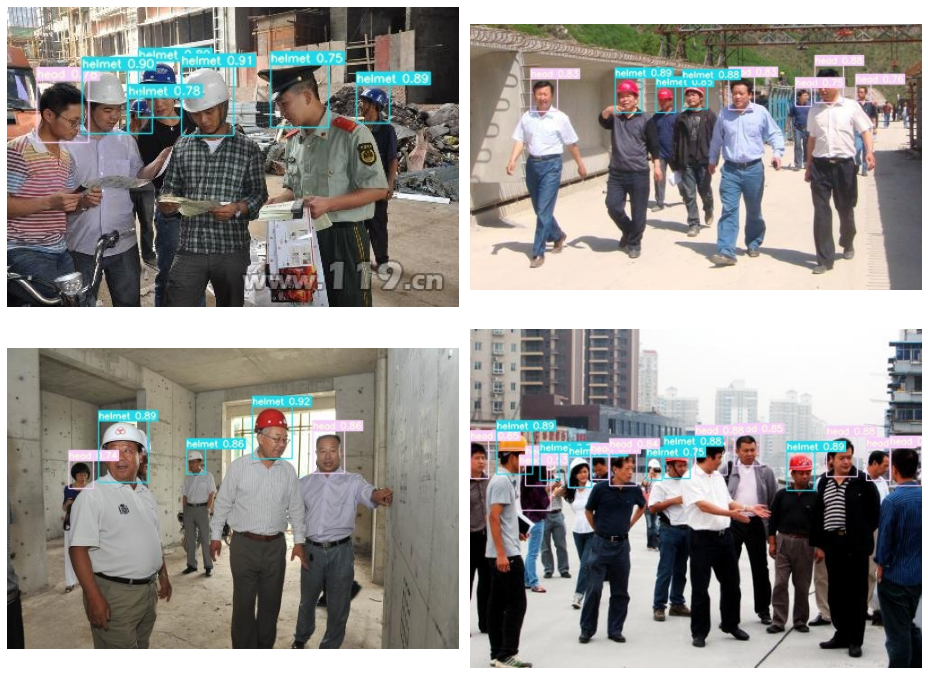

In [12]:
# visualize detection results
bbox_img1 = plt.imread("runs/detect/exp_hardhat_img544_epoch300/005382_jpg.rf.bad5f80a3fa19ab150532b976adaa2f1.jpg")
bbox_img2 = plt.imread("runs/detect/exp_hardhat_img544_epoch300/005398_jpg.rf.e985245df68dd22ebdb6312ab2dc9fc2.jpg")
bbox_img3 = plt.imread("runs/detect/exp_hardhat_img544_epoch300/005407_jpg.rf.c04655757eebeae99b5dc10d9f57972a.jpg")
bbox_img4 = plt.imread("runs/detect/exp_hardhat_img544_epoch300/005457_jpg.rf.44b81185f7ddc9286805c567057cf9a5.jpg")

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.imshow(bbox_img1)
plt.axis("off") 

plt.subplot(2, 2, 2)
plt.imshow(bbox_img2)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(bbox_img3)
plt.axis("off") 

plt.subplot(2, 2, 4)
plt.imshow(bbox_img4)
plt.axis("off")

plt.tight_layout()
plt.show()